In [28]:
from transformers import AutoModelForUniversalSegmentation
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-instance")
model.to(DEVICE)
model.eval()

Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value): Lin

In [29]:
import pandas as pd
from pyprojroot import here
from pathlib import Path
import numpy as np
import torch

# Download dataset if not already present
if not (here(r"data/sign_language_mnist/sign_mnist_train.csv").exists()):
  import kagglehub
  dwnl_path: str = kagglehub.dataset_download(
    "datamunge/sign-language-mnist",
  )
  # move the downloaded files to the correct location
  import shutil
  dest_dir = here(r"data/sign_language_mnist")
  dest_dir.mkdir(parents=True, exist_ok=True)
  shutil.move(
    Path(dwnl_path) / "sign_mnist_train.csv",
    dest_dir / "sign_mnist_train.csv"
  )
  shutil.move(
    Path(dwnl_path) / "sign_mnist_test.csv",
    dest_dir / "sign_mnist_test.csv"
  )
class SignMNIST(torch.utils.data.Dataset):
  def __init__(self, path: Path):
    self.df = pd.read_csv(path)
    self.target: np.array = self.df["label"].values
    self.data = self.df.drop(columns=["label"]).values
    self.data = self.data.reshape(self.data.shape[0], 28, 28)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: list[int]) -> tuple:
    image = self.data[index]  # shape (28, 28)

    image = image.astype(np.float32) / 255.0  # min max Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add channel dimension (C x H x W)

    label = self.target[index]
    label = torch.tensor(label, dtype=torch.int64)

    return image, label

  @staticmethod
  def label_to_letter(label: int) -> str:
    return chr(label + 65)

  @property
  def shape(self) -> tuple:
    return self.data.shape, self.target.shape
data = SignMNIST(here(r"data/sign_language_mnist/sign_mnist_train.csv"))
pd.read_csv(here(r"data/sign_language_mnist/sign_mnist_train.csv"))

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


Label: G (6)


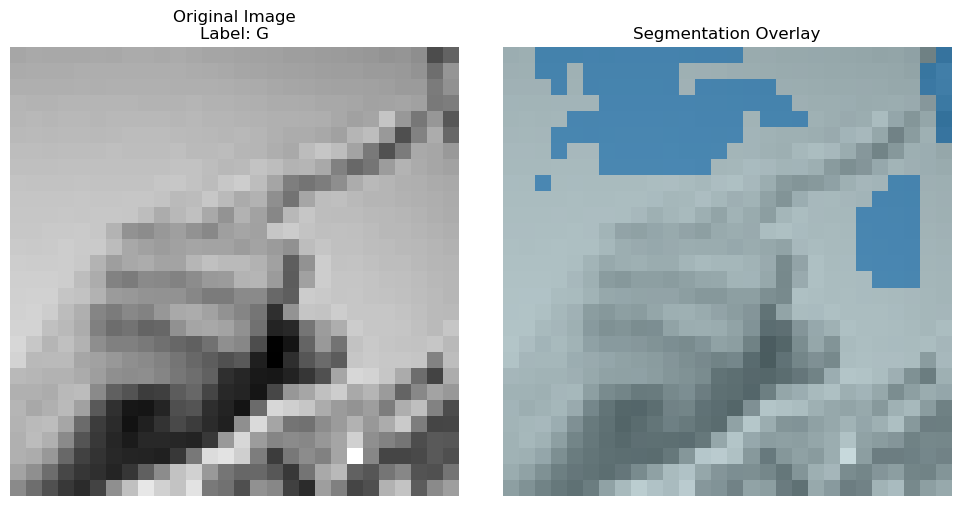

Segmentation mask shape: torch.Size([28, 28])
Unique segments: tensor([3, 6])
Segment 3 pixels (likely hand): 120
Segment 6 pixels (likely background): 664


In [31]:
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.colors as mcolors

# Get the first image from the dataset
first_image, first_label = data[1]
print(f"Label: {data.label_to_letter(first_label)} ({first_label})")

# Convert the grayscale image to PIL Image and then to RGB for the model
# The image is currently (1, 28, 28), we need to squeeze and convert
image_array = (first_image.squeeze() * 255).astype(np.uint8)  # Convert back to 0-255 range
pil_image = Image.fromarray(image_array, mode='L')  # Create PIL image from grayscale
rgb_image = pil_image.convert('RGB')  # Convert to RGB for the model

# Initialize the image processor
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-instance")

# Preprocess the image
inputs = processor(images=rgb_image, return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

# Run inference
with torch.no_grad():
  outputs = model(**inputs)

# Post-process the results
seg_mask = processor.post_process_semantic_segmentation(outputs, target_sizes=[rgb_image.size[::-1]])[0]

# Create overlay visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(pil_image, cmap='gray')
axes[0].set_title(f'Original Image\nLabel: {data.label_to_letter(first_label)}')
axes[0].axis('off')

# Overlay: Original image with segmentation mask
seg_mask_np = seg_mask.cpu().numpy()
axes[1].imshow(rgb_image)
# Create a colormap for the overlay
cmap = plt.cm.tab20
norm = mcolors.Normalize(vmin=seg_mask_np.min(), vmax=seg_mask_np.max())
overlay = cmap(norm(seg_mask_np))
# Set alpha channel based on whether it's background (class 6) or foreground
alpha = np.where(seg_mask_np == 6, 0.3, 0.7)  # Lower alpha for background, higher for foreground
overlay[..., 3] = alpha
axes[1].imshow(overlay)
axes[1].set_title('Segmentation Overlay')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Segmentation mask shape: {seg_mask.shape}")
print(f"Unique segments: {torch.unique(seg_mask)}")
print(f"Segment 3 pixels (likely hand): {(seg_mask == 3).sum().item()}")
print(f"Segment 6 pixels (likely background): {(seg_mask == 6).sum().item()}")

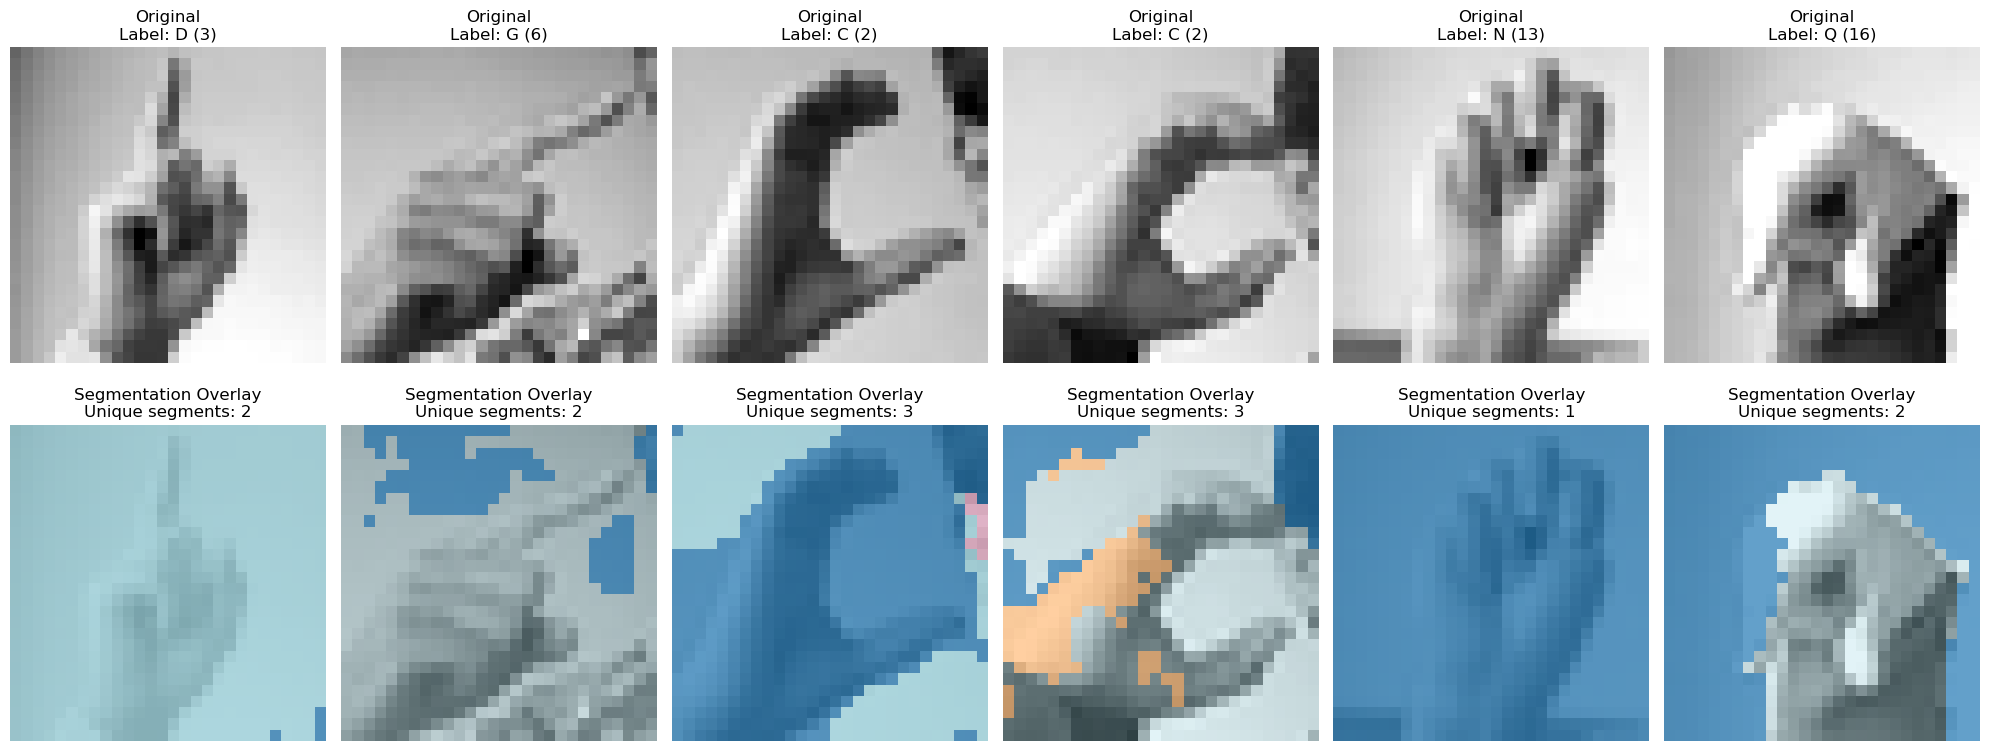


Segmentation Statistics:
Example 0 - Label: D
  Unique segments: [2, 3]
  Foreground pixels (class 3): 780
  Background pixels (class 6): 0

Example 0 - Label: D
  Unique segments: [2, 3]
  Foreground pixels (class 3): 780
  Background pixels (class 6): 0

Example 1 - Label: G
  Unique segments: [3, 6]
  Foreground pixels (class 3): 120
  Background pixels (class 6): 664

Example 1 - Label: G
  Unique segments: [3, 6]
  Foreground pixels (class 3): 120
  Background pixels (class 6): 664

Example 2 - Label: C
  Unique segments: [0, 2, 3]
  Foreground pixels (class 3): 190
  Background pixels (class 6): 0

Example 2 - Label: C
  Unique segments: [0, 2, 3]
  Foreground pixels (class 3): 190
  Background pixels (class 6): 0

Example 3 - Label: C
  Unique segments: [0, 1, 6]
  Foreground pixels (class 3): 0
  Background pixels (class 6): 576

Example 3 - Label: C
  Unique segments: [0, 1, 6]
  Foreground pixels (class 3): 0
  Background pixels (class 6): 576

Example 4 - Label: N
  Unique 

In [32]:
# Show multiple examples from the dataset
num_examples = 6
fig, axes = plt.subplots(2, num_examples, figsize=(20, 8))

for i in range(num_examples):
    # Get image and label
    image, label = data[i]
    letter = data.label_to_letter(label)
    
    # Convert to PIL and RGB
    image_array = (image.squeeze() * 255).astype(np.uint8)
    pil_image = Image.fromarray(image_array, mode='L')
    rgb_image = pil_image.convert('RGB')
    
    # Process image for segmentation
    inputs = processor(images=rgb_image, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process results
    seg_mask = processor.post_process_semantic_segmentation(outputs, target_sizes=[rgb_image.size[::-1]])[0]
    seg_mask_np = seg_mask.cpu().numpy()
    
    # Original image (top row)
    axes[0, i].imshow(pil_image, cmap='gray')
    axes[0, i].set_title(f'Original\nLabel: {letter} ({label})')
    axes[0, i].axis('off')
    
    # Segmentation overlay (bottom row)
    axes[1, i].imshow(rgb_image)
    cmap = plt.cm.tab20
    norm = mcolors.Normalize(vmin=seg_mask_np.min(), vmax=seg_mask_np.max())
    overlay = cmap(norm(seg_mask_np))
    alpha = np.where(seg_mask_np == 6, 0.3, 0.7)
    overlay[..., 3] = alpha
    axes[1, i].imshow(overlay)
    axes[1, i].set_title(f'Segmentation Overlay\nUnique segments: {len(torch.unique(seg_mask))}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Print statistics for all examples
print("\nSegmentation Statistics:")
for i in range(num_examples):
    image, label = data[i]
    letter = data.label_to_letter(label)
    
    image_array = (image.squeeze() * 255).astype(np.uint8)
    pil_image = Image.fromarray(image_array, mode='L')
    rgb_image = pil_image.convert('RGB')
    
    inputs = processor(images=rgb_image, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    seg_mask = processor.post_process_semantic_segmentation(outputs, target_sizes=[rgb_image.size[::-1]])[0]
    
    print(f"Example {i} - Label: {letter}")
    print(f"  Unique segments: {torch.unique(seg_mask).tolist()}")
    print(f"  Foreground pixels (class 3): {(seg_mask == 3).sum().item()}")
    print(f"  Background pixels (class 6): {(seg_mask == 6).sum().item()}")
    print()